In [170]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from docplex.mp.model import Model as CplexModel
import docplex.mp.solution as CplexSol

import gurobipy as gb

## Leitura dos dados

In [171]:
xlsx = pd.ExcelFile('Dados trab PO1.xlsx')
df1 = pd.read_excel(xlsx, 'Pontos Turisticos')
df2 = pd.read_excel(xlsx, 'Recompensa por horario', header=None)
df3 = pd.read_excel(xlsx, 'Custo (reais)', header=None)
df4 = pd.read_excel(xlsx, 'Tempo (min)', header=None)

In [172]:
toy_size = 12
df1 = df1.head(toy_size)
df2 = df2.loc[:toy_size,:]
df3 = df3.loc[:toy_size,:toy_size]
df4 = df4.loc[:toy_size,:toy_size]

In [173]:
CF = np.asarray(df1['Custo Fixo'])       #custo fixo
Ta = np.asarray(df1['Abre - horario'])   #tempo de abertura da janela
Tf = np.asarray(df1['Fecha - horario'])  #tempo de encerramento da janela
Tp = np.asarray(df1['Permanecia'])       #tempo de permanencia em um ponto
RS = np.asarray(df1['Avaliacao'])        #recompensa fixa
RO = np.asarray(df2)                     #recompensa por tempo de chegada
R_max = RS.max() + RO.max()              #recompensa maxima
C = np.asarray(df3)                      #custo de viagem entre dois pontos
CV_max = C.max()                         #custo de viagem maximo
CF_max = CF.max()                        #custo fixo maximo
Td = np.asarray(df4)                     #tempo de deslocamento entre dois pontos
T_max = 24                               #horario max de chagada em um ponto
B = 1000000                              #valor auxiliar
O = 4                                    #ponto de origem
N = len(df1)                             #quantidade de pontos
D = 1                                    #quantidade de dias para visita
K = 24                                   #quantidade de janelas de tempo para recompensa (tabela RO)

## Plot do grafo baseado no custo e no tempo

### Custo de viagem

In [174]:
G = nx.from_numpy_matrix(C)
pos = nx.spring_layout(G)
pos2 = nx.kamada_kawai_layout(G, dist=C)

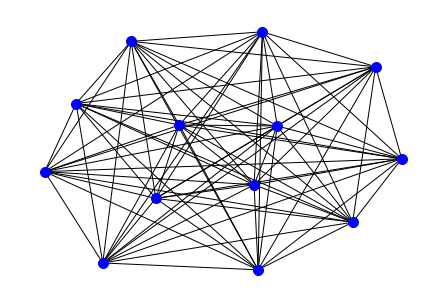

In [175]:
options = {
    'node_color': 'blue',
    'node_size': 100,
    'width': 1,
}
nx.draw(G, pos=pos, **options)

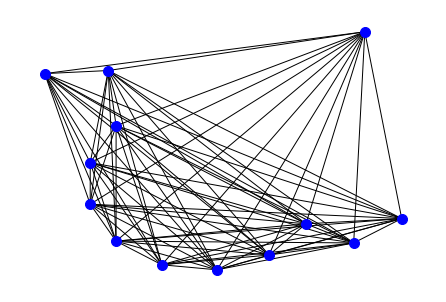

In [176]:
options = {
    'node_color': 'blue',
    'node_size': 100,
    'width': 1,
}
nx.draw(G, pos=pos2, **options)

### Tempo de viagem

In [177]:
G2 = nx.from_numpy_matrix(Td)
pos = nx.spring_layout(G2)
pos2 = nx.kamada_kawai_layout(G2, dist=Td)

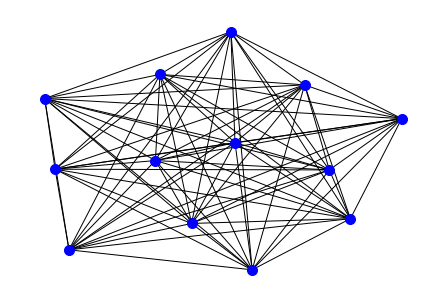

In [178]:
options = {
    'node_color': 'blue',
    'node_size': 100,
    'width': 1,
}
nx.draw(G2, pos=pos, **options)

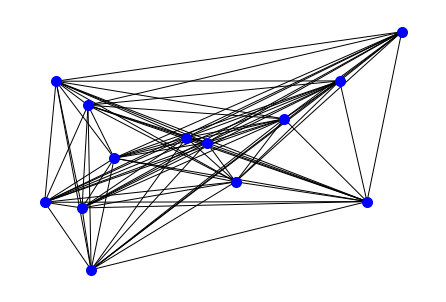

In [179]:
pos2 = nx.kamada_kawai_layout(G2, dist=Td)
options = {
    'node_color': 'blue',
    'node_size': 100,
    'width': 1,
}
nx.draw(G2, pos=pos2, **options)

## Modelagem

### Gurobi

In [180]:
model = gb.Model("PCTSP_gurobi")

x = model.addVars(N, N, D, vtype = gb.GRB.BINARY, name='x')
y = model.addVars(N, K, vtype = gb.GRB.BINARY, name ='y')
t = model.addVars(N, vtype = gb.GRB.CONTINUOUS, name ='t')

t[O] = 6 #partida da origem a partir das 6
for i in range(N):
    for d in range(D):
        x[i,i,d] = 0

model.setObjective(gb.quicksum(gb.quicksum(((RO[i,k] + RS[i])/R_max)*y[i,k] for i in range(N)) for k in range(K)) - gb.quicksum(gb.quicksum(gb.quicksum((C[i,j]/CV_max + CF[i]/CF_max)*x[i,j,d] for i in range(N)) for j in range(N)) for d in range(D)), gb.GRB.MAXIMIZE) 

model.addConstrs(gb.quicksum(x[i,j,d] for d in range(D)) <= 1 for i in range(N) for j in range(N))
model.addConstrs(gb.quicksum(gb.quicksum(x[i,j,d] for d in range(D)) for j in range(N)) == gb.quicksum(y[i,k] for k in range(K)) for i in range(N))
model.addConstr(gb.quicksum(gb.quicksum(x[O,j,d] for j in range(N)) for d in range(D)) == D)
model.addConstr(gb.quicksum(gb.quicksum(x[i,O,d] for i in range(N)) for d in range(D)) == D)
model.addConstrs(gb.quicksum(y[i,k] for k in range(K)) <= 1 for i in range(N))
#model.addConstrs(t[i] + Tp[i] + Td[i,O] <= T_max for i in range(N))
model.addConstrs(t[i] <= T_max for i in range(N))
model.addConstrs(B - B*gb.quicksum(y[i,k] for k in range(K)) + t[i] >= Ta[i] for i in range(N))
model.addConstrs(t[i] + Tp[i] - B + B*gb.quicksum(y[i,k] for k in range(K)) <= Tf[i] for i in range(N))
model.addConstrs(t[j] - t[i] - B*gb.quicksum(x[i,j,d] for d in range(D)) >= -B + Td[i,j] + Tp[i] for i in range(N) for j in range(N))
model.addConstrs(t[i] <= B*gb.quicksum(y[i,k] for k in range(K)) for i in range(N))
model.addConstrs(t[i] <= gb.quicksum(k*y[i,k] for k in range(K)) + 1 for i in range(N))
model.addConstrs(t[i] - 0.1 >= gb.quicksum(k*y[i,k] for k in range(K)) for i in range(N))

# model.Params.timeLimit=3600 # TEMPO DE EXECUÇÃO
# model.Params.MIPGap = 0.1
model.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 386 rows, 444 columns and 2718 nonzeros
Model fingerprint: 0x2b6c04d1
Variable types: 12 continuous, 432 integer (432 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [9e-02, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 1e+06]
Presolve removed 173 rows and 61 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 4 available processors)

Solution count 0
No other solutions better than -1e+100

Model is infeasible
Best objective -, best bound -, gap -


In [181]:
print("função objetivo: ",str(round(model.ObjVal,2)))
for v in model.getVars():
    if v.x > 0.9:
        print(str(v.VarName)+"="+str(v.x))

AttributeError: Unable to retrieve attribute 'ObjVal'

### Cplex